In [1]:
import sys
import os 
import pandas as pd 
import numpy as np
from torchvision import datasets
import torch.nn as nn
from torchvision import transforms as T
import torch
import torch.nn.functional as F

In [2]:
path = '../input/dogs-cats-images/'

In [3]:
train_transform = T.Compose([T.Resize(256),T.CenterCrop(224),T.RandomRotation(30),
                             T.RandomHorizontalFlip(),T.RandomVerticalFlip(),T.ToTensor()])
test_transform = T.Compose([T.Resize(256),T.CenterCrop(224),T.ToTensor()])

In [4]:
print(os.listdir('../input/dogs-cats-images/'))

['dataset', 'dog vs cat']


In [5]:
train_dataset = datasets.ImageFolder('../input/dogs-cats-images/dataset/training_set',transform=train_transform)
trainLoader = torch.utils.data.DataLoader(train_dataset,batch_size = 32,shuffle=True)
test_dataset = datasets.ImageFolder('../input/dogs-cats-images/dataset/test_set',transform=test_transform)
testLoader = torch.utils.data.DataLoader(test_dataset,batch_size = 32)

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'tensor(1)')

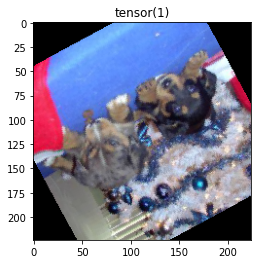

In [7]:
images, labels = next(iter(trainLoader))

plt.imshow(np.transpose(images[8],(1,2,0)))
plt.title(labels[8])

In [8]:
images.shape

torch.Size([32, 3, 224, 224])

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(43264,500)
        self.fc2 = nn.Linear(500,2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,43264)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=43264, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)


In [11]:
cuda_available = torch.cuda.is_available()

if cuda_available:
    print('True')
else:
    print('False')

True


In [12]:
if cuda_available:
    model.cuda()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [14]:
n_epochs = 15
valid_loss_min = np.Inf

for epoch in range(1,n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    
    for data,target in trainLoader:
        if cuda_available:
            data,target = data.cuda(),target.cuda()
#         target=target.unsqueeze(dim=1)
#         target = target.float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    
    model.eval()
    
    for data,target in testLoader:
        if cuda_available:
            data,target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output,target)
        valid_loss+=loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainLoader.sampler)
    valid_loss = valid_loss/len(testLoader.sampler)
    
    print('Epoch: {} , Training Loss: {:.6f}, Validation Loss: {:.6f}'.format(epoch,train_loss,valid_loss))
    
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_dogs.pt')
        valid_loss_min = valid_loss

Epoch: 1 , Training Loss: 1.438675, Validation Loss: 0.693554
Validation loss decreased (inf --> 0.693554).  Saving model ...
Epoch: 2 , Training Loss: 0.693645, Validation Loss: 0.693320
Validation loss decreased (0.693554 --> 0.693320).  Saving model ...
Epoch: 3 , Training Loss: 0.693810, Validation Loss: 0.693770
Epoch: 4 , Training Loss: 0.693587, Validation Loss: 0.693320
Validation loss decreased (0.693320 --> 0.693320).  Saving model ...
Epoch: 5 , Training Loss: 0.693500, Validation Loss: 0.693509
Epoch: 6 , Training Loss: 0.693416, Validation Loss: 0.693740
Epoch: 7 , Training Loss: 0.693469, Validation Loss: 0.693582
Epoch: 8 , Training Loss: 0.693366, Validation Loss: 0.694660
Epoch: 9 , Training Loss: 0.694057, Validation Loss: 0.694315
Epoch: 10 , Training Loss: 0.693829, Validation Loss: 0.693246
Validation loss decreased (0.693320 --> 0.693246).  Saving model ...
Epoch: 11 , Training Loss: 0.693614, Validation Loss: 0.693175
Validation loss decreased (0.693246 --> 0.693